In [1]:
from statsmodels.tsa.arima_process import ArmaProcess

import numpy as np

np.random.seed(42)
ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, 0, 0])

MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)


AttributeError: 'numpy.ndarray' object has no attribute 'head'

Plot your simulated moving average.

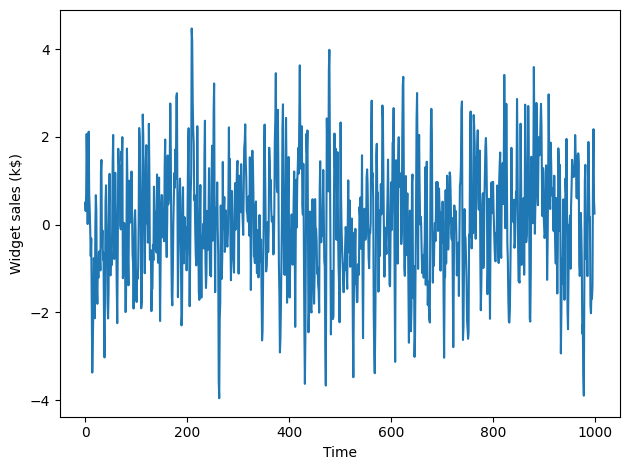

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(MA2_process)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.tight_layout()

Run the ADF test, and check if the process is stationary.

In [3]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(MA2_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -14.005444309194495
p-value: 3.7956016167135026e-26


Plot the ACF, and see if there are significant coefficients after lag 2.

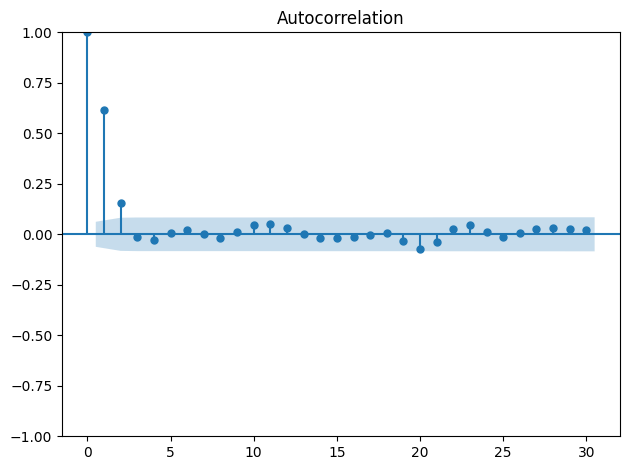

In [4]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(MA2_process, lags=30);

plt.tight_layout()

Separate your simulated series into train and test sets. Take the first 800 timesteps for the train set, and assign the rest to the test set.

In [5]:
import pandas as pd

df = pd.DataFrame(MA2_process)

train = df[:800]
test = df[800:]

print(len(train))
print(len(test))

800
200


Make forecasts over the test set. Use the mean, last value, and an MA(2) model.
Make sure you repeatedly forecast 2 timesteps at a time using the recursive_forecast function we defined.

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)

        return pred_MA

In [7]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW,'last')
pred_MA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,0,pred_mean,pred_last_value,pred_MA
800,0.973560,-0.017430,0.259693,0.065366
801,0.337338,-0.017430,0.259693,0.017984
802,-0.086834,-0.015752,0.337338,-0.180397
803,-0.530580,-0.015752,0.337338,-0.116820
804,-0.821708,-0.016481,-0.530580,-0.405768


Plot your forecasts.

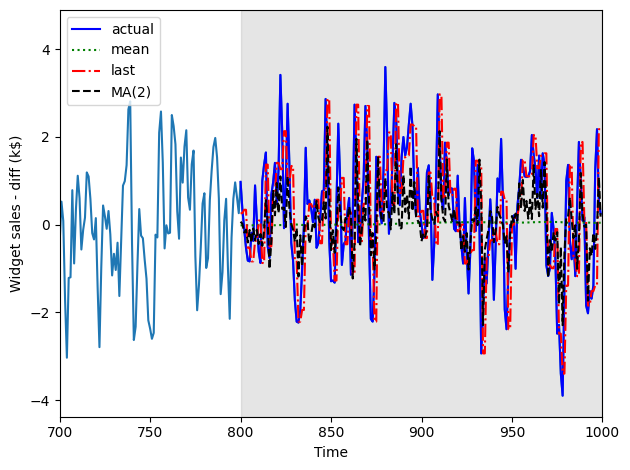

In [10]:
fig, ax = plt.subplots()

ax.plot(df)
ax.plot(pred_df[0], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

ax.set_xlim(700, 1000)

plt.tight_layout()

Measure the MSE, and identify your champion model.

In [12]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df[0],pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df[0],pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df[0],pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

1.8635013982365882 1.988201688527919 1.2323542190608936


Plot your MSEs in a bar plot.

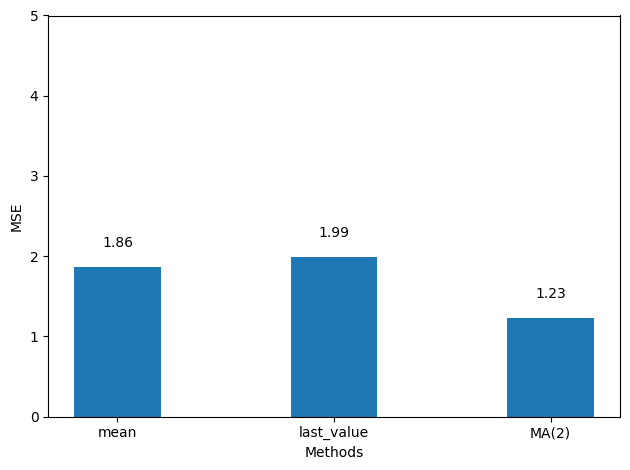

In [13]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()